In [18]:
#import external packages
!pip install gym-super-mario-bros==7.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
#import libraries and mount to google drive
from google.colab import drive
from pathlib import Path

import torch
from torch import nn
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros

from torch.nn.modules.module import register_module_forward_pre_hook
from torch.nn.modules.module import register_module_forward_pre_hook
from gym.wrappers.monitoring.video_recorder import VideoRecorder

import matplotlib.pyplot as plt

drive.mount('/content/gdrive',force_remount= True)

#initialise the environment
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)

#limit the action space to moving right and right with a jump
env = JoypadSpace(env, [["right"], ["right", "A"]])
env.reset()

#observe original state space
next_state,reward,done,_,info = env.step(action = 0)
print(str(next_state.shape)+'\n'+str(reward)+'\n'+str(done)+'\n'+str(info))

Mounted at /content/gdrive
(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


In [20]:
#pre-process the environment using reduction of state space. Adapted from https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
if gym.__version__ < '0.26':
    env = FrameStack(env, num_stack=4, new_step_api=True)
else:
    env = FrameStack(env, num_stack=4)

In [21]:
#define the classes for the neural networks

class DuellingNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim

        self.feature = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
        
        self.value = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.online = nn.ModuleDict({
            'feature': self.feature,
            'advantage': self.advantage,
            'value': self.value
        })

        self.target = copy.deepcopy(self.online)

    def forward(self,input,model):
        if model == "online":
            feature = self.online['feature'](input)
            advantage = self.online['advantage'](feature)
            value = self.online['value'](feature)
            q = value + advantage - advantage.mean(dim=1, keepdim=True)

            return q

        elif model == "target":
            feature = self.target['feature'](input)
            advantage = self.target['advantage'](feature)
            value = self.target['value'](feature)
            q = value + advantage - advantage.mean(dim=1, keepdim=True)
            return q

class DoubleNet(nn.Module):
    def __init__(self,input_dim, output_dim):
        super().__init__()
        c, h, w = input_dim
        self.online = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )

        self.target = copy.deepcopy(self.online)

        # Q_target parameters are frozen.
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)


In [37]:
class Mario_Agent():
  #initialise the agent with the corresponding network based on the arguments passed
  def __init__(self,save_dir,duelling,random,env):
    
    #state and action dimensions
    self.state_dim = (4,84,84)
    self.environment = env
    self.action_dim = env.action_space.n
    self.save_dir = save_dir

    self.device = "cuda" if torch.cuda.is_available() else "cpu"

    #choice of network
    if duelling:
      print("duelling activated")
      self.nn = DuellingNet(self.state_dim, self.action_dim).float()
      self.nn.to(device = self.device)

    else:
      self.nn = DoubleNet(self.state_dim, self.action_dim).float()
      self.nn = self.nn.to(device=self.device)

    #RL parameters
    self.random = random
    self.exploration_rate = 1
    self.exploration_rate_decay = 0.99
    self.exploration_rate_min = 0.1
    self.curr_step = 0
    self.duelling = duelling
    self.save_every = 5e5
    self.memory = deque(maxlen=100000)
    self.batch_size = 32
    self.gamma = 0.9
    self.optimizer = torch.optim.Adam(self.nn.parameters(), lr=0.00025)
    self.loss = torch.nn.SmoothL1Loss()
    self.burnin = 1e4 
    self.learn_every = 3 
    self.synch_every = 1e4

  #action selection based on epsilon greedy
  def choose_action(self,state):
    if(np.random.rand()<self.exploration_rate):
      action_choice = np.random.randint(self.action_dim)
    
    else:
      state = state[0].__array__() if isinstance(state, tuple) else state.__array__()
      state = torch.tensor(state, device=self.device).unsqueeze(0)
      action_values = self.nn(state, model="online")
      action_choice = torch.argmax(action_values, axis=1).item()

    if(not self.random):
      # decrease exploration_rate only if random policy is not enacted
      self.exploration_rate *= self.exploration_rate_decay
      self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)

    # increment step
    self.curr_step += 1
    return action_choice

  #store experience to memory buffer
  def store_experience(self,state,next_state,action,reward,done):
    def first_if_tuple(x):
      return x[0] if isinstance(x, tuple) else x
    state = first_if_tuple(state).__array__()
    next_state = first_if_tuple(next_state).__array__()

    state = torch.tensor(state, device=self.device)
    next_state = torch.tensor(next_state, device=self.device)
    action = torch.tensor([action], device=self.device)
    reward = torch.tensor([reward], device=self.device)
    done = torch.tensor([done], device=self.device)

    self.memory.append((state, next_state, action, reward, done,))


  def sample_experience(self):
    batch = random.sample(self.memory, self.batch_size)
    state, next_state, action, reward, done = map(torch.stack, zip(*batch))
    return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

  def update_Q_online(self, td_estimate, td_target):
        loss = self.loss(td_estimate, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

  def td_estimate(self, state, action):
        current_Q = self.nn(state, model="online")[
            np.arange(0, self.batch_size), action
        ]  # Q_online(s,a)
        return current_Q

  @torch.no_grad()
  def td_target(self, reward, next_state, done):
    next_state_Q = self.nn(next_state, model="online")
    best_action = torch.argmax(next_state_Q, axis=1)
    next_Q = self.nn(next_state, model="target")[
    np.arange(0, self.batch_size), best_action]
    return (reward + (1 - done.float()) * self.gamma * next_Q).float()

  def experience_replay(self):

    #synch the target and the online networks
    if self.curr_step % self.synch_every == 0:
      self.nn.target.load_state_dict(self.nn.online.state_dict())

    #save to folder every save steps
    if self.curr_step % self.save_every == 0:
      self.save()

    #if the agent has not reached the burn in period return
    if self.curr_step<self.burnin:
      return

    #batch size can never be greater than the size of the buffer
    if self.batch_size > len(self.memory):
      return

        
    if self.curr_step % self.learn_every != 0:
      return

    # Sample from memory
    state, next_state, action, reward, done = self.sample_experience()

    # Get TD estimate
    td_est = self.td_estimate(state, action)

    # Get TD Target
    td_tgt = self.td_target(reward, next_state, done)

    # Backpropagate loss through Q_online
    self.update_Q_online(td_est, td_tgt)
    return

  #save the agent path at certain amount of time 
  def save(self):
        if(self.duelling):
          save_path = (
              Path(self.save_dir) / f"mario_duelling_{int(self.curr_step // self.save_every)}.chkpt"
          )
          torch.save(
              dict(model=self.nn.state_dict(), exploration_rate=self.exploration_rate),
              save_path,
          )
        elif(not self.duelling):
          save_path = (
              Path(self.save_dir) / f"mario_ddqn_{int(self.curr_step // self.save_every)}.chkpt"
          )
          torch.save(
              dict(model=self.nn.state_dict(), exploration_rate=self.exploration_rate),
              save_path,
          )
        else:
          print(f"MarioNet saved to {save_path} at step {self.curr_step}")


  def run_agent(self,number_of_episodes):
    episode_rewards = []
    average_rewards = []
    epsilon = []

    for e in range(number_of_episodes):
      e_reward = 0
      state = self.environment.reset()
      while True:
        #choose and take action
        action = self.choose_action(state)

        next_state, reward, done, trunc, info = self.environment.step(action)
        
        #store the reward in memory
        e_reward+=reward
        self.store_experience(state,next_state,action,reward,done)

        #learn
        self.experience_replay()

        #update the state
        state = next_state

        if done or info['flag_get']:
          break
    
      epsilon.append(self.exploration_rate)
      episode_rewards.append(e_reward)

      if e%10 == 0:
        average_rewards.append(np.mean(episode_rewards[-10:]))
    return((episode_rewards,average_rewards,epsilon))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
#running episodes is an expensive process so it is better to have initial plots in case the run time stops
def plot_learnings(thing,title,other_thing):

  fig, ax = plt.subplots(figsize=(6,4))
  x = np.arange(len(thing))
  ax.set_title(title)
  ax.set_xlabel('episode number')
  ax.set_ylabel(other_thing)
  ax.plot(x,thing)
  fig.tight_layout()

In [35]:
def record_video(checkpoint,file_name,duelling,random):
  #record a video for a particular checkpoint (please load the appropriate files)

  mario = Mario_Agent(None,duelling,random,env)

  # Load the checkpoint file
  checkpoint_path = F"/content/gdrive/MyDrive/Colab Notebooks/"+checkpoint
  checkpoint = torch.load(checkpoint_path)
  mario.nn.load_state_dict(checkpoint['model'])
  mario.exploration_rate = checkpoint['exploration_rate']

  # Start recording the video
  video_path = '/content/gdrive/MyDrive/Colab Notebooks/'+file_name +".mp4"
  video_recorder = VideoRecorder(env, video_path)

  # Play the game!
  state = env.reset()
  while True:
    # Run agent on the state
    action = mario.choose_action(state)

    # Agent performs action
    next_state, reward, done, trunc, info = env.step(action)

    # Record the video
    video_recorder.capture_frame()

    # Update state
    state = next_state

    # Check if end of game
    if done or info["flag_get"]:
        break

  # Stop recording the video
  video_recorder.close()


In [38]:
# #create the agent ddqn
save_dir = F"/content/gdrive/MyDrive/Colab Notebooks/"

# #ddqn mario
mario_ddqn = Mario_Agent(save_dir,False,False,env)
rewards1,average_rewards1,epsilon1 = mario_ddqn.run_agent(100)
plot_learnings(rewards1,"DDQN rewards",'reward')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT
I MADE IT


KeyboardInterrupt: ignored

duelling activated


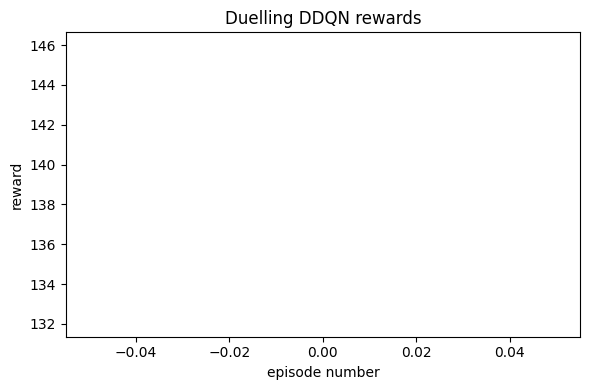

In [ ]:
#create the agent duelling

#duelling mario
mario_duelling = Mario_Agent(save_dir,True,False,env)
rewards2,average_rewards2,epsilon2 = mario_ddqn.run_agent(10000)

plot_learnings(rewards2,"Duelling DDQN rewards",'reward')

In [ ]:
#create the agent random

#random mario
mario_random = Mario_Agent(save_dir,True,True,env)
rewards3,average_rewards3,epsilon3 = mario_ddqn.run_agent(100)

fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(average_rewards3))
ax.set_title('10 episode average over 100 episodes')
ax.set_xlabel('episode number')
ax.set_ylabel('average reward')
ax.plot(x,average_rewards3,label = "Purely random actions")
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(average_rewards1))
ax.set_title('Comparison of DDQN and Duelling DQN using average of 10 episodes')
ax.set_xlabel('episode number')
ax.set_ylabel('average reward')
ax.plot(x,average_rewards1,label = "DDQN")
ax.plot(x,average_rewards2,label = "Duelling DQN")
ax.legend(loc='upper left')
fig.tight_layout()

In [ ]:
#now record resulting video for whatever checkpoints you have saved for any of the agent. This is prone to crashing so we get our outputs then manually generate the videos from the output
record_video("mario_ddqn_3.chkpt","Double",False,False)